# Kaggle TGS Geoseismic competition

In [3]:
#!pip install -r requirements.txt

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2782968327026120156
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286285517
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4007177297723420039
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 4029:00:00.0, compute capability: 3.7"
]


# API Credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

Place this file on your Google Drive anywhere.

With the next snippet you download your credentials to Colab and you can start using Kaggle API

In [2]:
!ls

datalab


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
#!kaggle datasets list

In [4]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0%|                                                | 0.00/322k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 322k/322k [00:00<00:00, 45.3MB/s]
  0%|                                                | 0.00/264k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 264k/264k [00:00<00:00, 89.5MB/s]
  0%|                                                | 0.00/922k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 922k/922k [00:00<00:00, 161MB/s]
 92%|█████████████████████████████████████▉   | 151M/163M [00:00<00:00, 133MB/s]
100%|█████████████████████████████████████████| 163M/163M [00:01<00:00, 157MB/s]
 45%|█████████████████                     | 17.0M/37.9M [00:00<00:00, 66.1MB/s]
100%|███████████████████████████████████████| 37.9M/37.9M [00:00<00:00, 124MB/s]


Reference: [https://github.com/Kaggle/kaggle-api](https://github.com/Kaggle/kaggle-api)

In [6]:
!ls /content

datalab


In [0]:
#!ls /content#/competitions/tgs-salt-identification-challenge

In [0]:
#!mv ~/.kaggle/competitions/tgs-salt-identification-challenge/ /

In [0]:
#!ls /

# Data Exploration

In [6]:
import zipfile
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/trainData')
zip_ref.close()

In [7]:
zip_ref = zipfile.ZipFile('test.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/testData')
zip_ref.close()

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm_notebook, tnrange, tqdm

from scipy.signal import medfilt2d

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
trainFolder = 'tgs-salt-identification-challenge/trainData/'
testFolder  = 'tgs-salt-identification-challenge/testData/'

In [3]:
!ls tgs-salt-identification-challenge/testData/

images


In [4]:
depthFile = pd.read_csv('depths.csv' )
depthFile.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [5]:
depthFile[depthFile['id'] == '4ac19fb269'].z.tolist()[0]

306

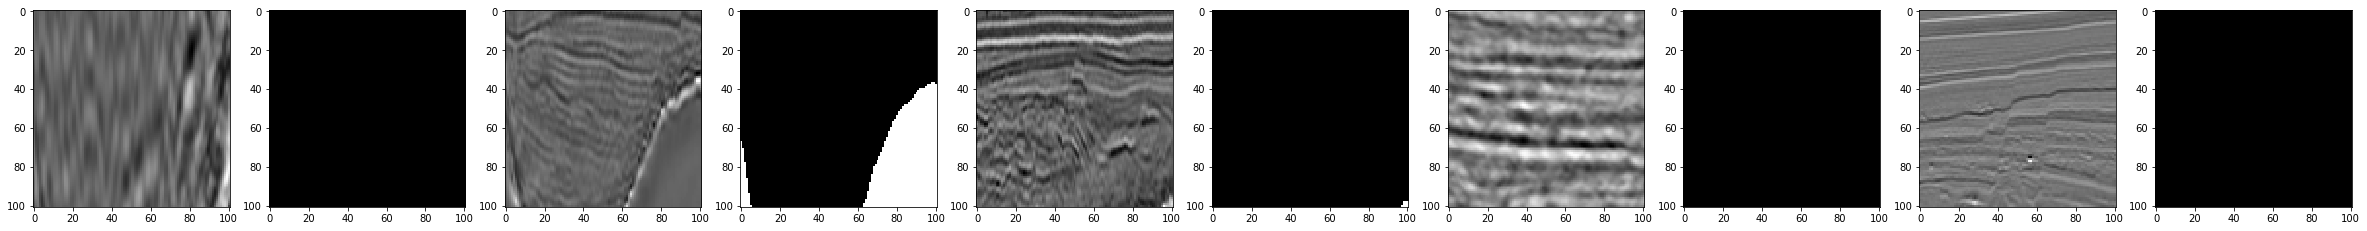

In [6]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(50,25))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(trainFolder + 'images/' + img_name + '.png')
    img_mask = load_img(trainFolder + 'masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [7]:
%load_ext autoreload
%autoreload 2

import ImageReader

In [8]:
train_ids = next(os.walk(trainFolder +"images"))[2]
test_ids = next(os.walk(testFolder +"images"))[2]

In [9]:
X_train, Y_train, depthVals = ImageReader.ReadSegmentationImages(trainFolder, depthFile)
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)
print('Mean: {} Std: {}'.format(X_train_mean, X_train_std))
X_train = (X_train-X_train_mean)/(2*X_train_std)

#X_test, d_test = ImageReader.ReadSegmentationImages(testFolder, depthFile, readMasks = False)
#X_test = (X_test-X_train_mean)/(2*X_train_std)

  1%|          | 35/4000 [00:00<00:11, 346.97it/s]

Getting images and masks ... 


100%|██████████| 4000/4000 [00:11<00:00, 351.47it/s]


Mean: 120.34612148318793 Std: 41.06966522016213


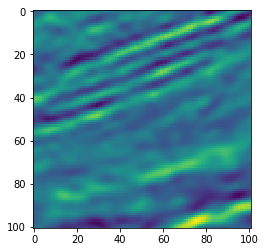

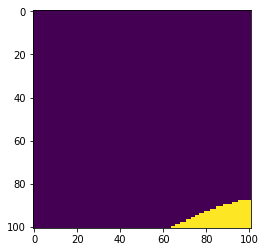

In [10]:
# Check if training data looks all right
ix = np.random.randint(0, len(train_ids))
#plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.imshow(X_train[ix,:,:,0])
plt.show()
plt.imshow(Y_train[ix,:,:,0])
plt.show()

# Keras datagen

In [11]:
valRatio = 0.12
nVal = int(len(X_train)*valRatio)
X_val = X_train[0:nVal]
Y_val = Y_train[0:nVal]
d_val = depthVals[0:nVal]

X_train0 = X_train[nVal:]
Y_train0 = Y_train[nVal:]
d_train0 = depthVals[nVal:]
X_train0.shape
print('{}, {}'.format(X_train0.shape, X_val.shape))

(3520, 101, 101, 1), (480, 101, 101, 1)


In [12]:
from keras.preprocessing.image import ImageDataGenerator

# we create two instances with the same arguments
data_gen_argsMask = dict(
                     rotation_range=1.0, #1.0,
                     #shear_range = 0.001, #0
                     zoom_range = 0.013, #0
                     width_shift_range=11, # 0.03,
                     height_shift_range=3, #0.3,
                     horizontal_flip=True,
                     fill_mode = "reflect"
                     #vertical_flip=True #see if helps
                    )

data_gen_args = {}
for key in data_gen_argsMask:
    data_gen_args[key] = data_gen_argsMask[key]
    
#data_gen_args['featurewise_center'] = True
#data_gen_args['featurewise_std_normalization'] = True
#data_gen_args['zca_whitening'] = True #this or normalization

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_argsMask)
depth_datagen = ImageDataGenerator()


seed=7
# Provide the same seed and keyword arguments to the fit and flow methods
image_datagen.fit(X_train0, augment=True, seed=seed)
#mask_datagen.fit(Y_train0, augment=True, seed=seed)
#depth_datagen.fit(d_train0, augment=False, seed=seed)

image_generator = image_datagen.flow(
    X_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

mask_generator = mask_datagen.flow(
    Y_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

depth_generator = depth_datagen.flow(
    d_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

bSize = 32
def multi_input_gen(X1, X2, X3):
    genX1 = image_datagen.flow(X1, seed=7, batch_size=bSize)
    genX2 = depth_datagen.flow(X2, seed=7, batch_size=bSize)
    genX3 = mask_datagen.flow( X3, seed=7, batch_size=bSize)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [X1i, X2i], X3i

train_generator = multi_input_gen(X_train0, d_train0, Y_train0) #zip( [image_generator, depth_generator] , [mask_generator] )

359.0


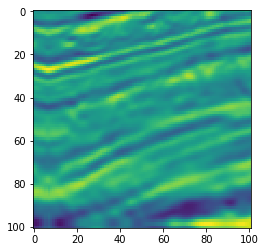

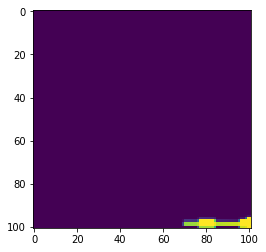

In [13]:
ans = next(train_generator)
print(ans[0][1][17,0,0,0])
plt.imshow( ans[0][0][17,:,:,0] )
plt.show()
plt.imshow( ans[1][17,:,:,0] )
plt.show()

# UNet model

In [52]:
import ModelUNet

from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, ZeroPadding2D, Cropping2D, Add, Conv2D
from keras.layers.core import Lambda

In [19]:
im_height = 101
im_width = 101
im_chan = 1


inputImg = Input((im_height, im_width, im_chan))
inputDepth = Input( (1,1,1) )

#s = Lambda(lambda x: x / 255) (inputImg)
s = inputImg

dd = Lambda(lambda x: x * 0.001) (inputDepth)

#s = ReflectionPadding2D( padding = ((13, 14), (13, 14)) ) (s)
s = ZeroPadding2D( padding = ((13, 14), (13, 14)) ) (s)

unet = ModelUNet.BuildUNet(convFunction = ModelUNet.ApplyDC, nFilter = 12, net_depth=4, nBorderRefinementConvs = 4)
s = unet([s,dd])

outputs = Cropping2D(cropping=((13, 14), (13, 14)) ) (s)

model = Model(inputs=[inputImg, inputDepth], outputs=[outputs])

model.compile(optimizer='adam', loss=ModelUNet.dice_loss, metrics=[ModelUNet.mean_iou])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1, 1, 1)      0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 128, 128, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1, 1, 1)      0           input_6[0][0]                    
__________________________________________________________________________________________________
UNet_d4 (M

In [64]:
#try to do stuff without reducing the scale
im_height = 101
im_width = 101
im_chan = 1


inputImg = Input((im_height, im_width, im_chan))
inputDepth = Input( (1,1,1) )

#s = Lambda(lambda x: x / 255) (inputImg)
s = inputImg

dd = Lambda(lambda x: x * 0.001) (inputDepth)

#s = ReflectionPadding2D( padding = ((13, 14), (13, 14)) ) (s)
s = ZeroPadding2D( padding = ((13, 14), (13, 14)) ) (s)

numFilters = 8
s = ModelUNet.ApplyDC4(s, numFilters)
s = ModelUNet.ApplyDC4(s, 2*numFilters)
sc1 = s

s = ModelUNet.ApplyDC4(s, 4*numFilters)
sc2 = s

s = ModelUNet.ApplyDC4(s, 8*numFilters)
sc3 = s

s = ModelUNet.ApplyDC4(s, 8*numFilters)

s = ModelUNet.ApplyDC4(s, 8*numFilters)
s = Add() ([s, sc3])

s = ModelUNet.ApplyConv(s, 4*numFilters)
s = Add() ([s, sc2])

s = ModelUNet.ApplyConv(s, 2*numFilters)
s = Add() ([s, sc1])

s = ModelUNet.ApplyConv(s, 2*numFilters)
s = ModelUNet.ApplyConv(s, 2*numFilters)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (s)


outputs = Cropping2D(cropping=((13, 14), (13, 14)) ) (outputs)

model = Model(inputs=[inputImg, inputDepth], outputs=[outputs])

model.compile(optimizer='adam', loss=ModelUNet.dice_loss, metrics=[ModelUNet.mean_iou])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 128, 128, 1)  0           input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 128, 128, 8)  80          zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
batch_normalization_113 (BatchN (None, 128, 128, 8)  32          conv2d_211[0][0]                 
__________________________________________________________________________________________________
conv2d_212

In [65]:
#unet.summary()

# Training

In [66]:
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.0032
    drop = 0.945
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [ ]:
earlystopper = EarlyStopping(patience=75, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
internalEval = ModelUNet.IntervalEvaluation( validation_data=( [X_val, d_val], Y_val), interval = 1 )
#results = model.fit([X_train0, d_train0], Y_train0, validation_split=0.08, batch_size=16, epochs=100, 
#                    callbacks=[earlystopper, checkpointer, lrate])

results = model.fit_generator(train_generator, epochs=200, steps_per_epoch=len(X_train0) / 32, 
                              validation_data=( [X_val, d_val], Y_val),
                              callbacks=[earlystopper, checkpointer, lrate, internalEval])


Epoch 1/200
Changing learning rate to 0.0032
110/110 [==============================] - 183s 2s/step - loss: 0.2861 - mean_iou: 0.5499 - val_loss: 0.3714 - val_mean_iou: 0.6011

Epoch 00001: val_loss improved from inf to 0.37135, saving model to model-tgs-salt-1.h5
480/480 [==============================] - 12s 25ms/step
Accurate validation score is 0.21833333333333332. Best so far is 0
Saving model-tgs-salt-IV.h5
Epoch 2/200
Changing learning rate to 0.0032
110/110 [==============================] - 165s 2s/step - loss: 0.2247 - mean_iou: 0.6227 - val_loss: 0.3528 - val_mean_iou: 0.6394

Epoch 00002: val_loss improved from 0.37135 to 0.35277, saving model to model-tgs-salt-1.h5
480/480 [==============================] - 8s 17ms/step
Accurate validation score is 0.26041666666666663. Best so far is 0.21833333333333332
Saving model-tgs-salt-IV.h5
Epoch 3/200
Changing learning rate to 0.0032
110/110 [==============================] - 166s 2s/step - loss: 0.2044 - mean_iou: 0.6515 - val_lo

In [ ]:
plt.plot(internalEval.score_list)

In [37]:
# list all data in history
print(results.history.keys())

dict_keys(['val_loss', 'loss', 'val_mean_iou', 'mean_iou'])


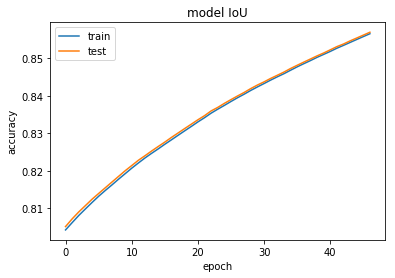

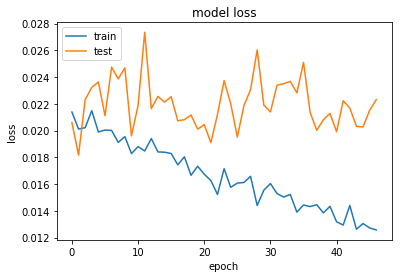

In [38]:
# summarize history for intersestion over union
plt.plot(results.history['mean_iou'])
plt.plot(results.history['val_mean_iou'])
plt.title('model IoU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
model = load_model('model-tgs-salt-IV.h5', custom_objects={'mean_iou': ModelUNet.mean_iou, 'dice_loss' : ModelUNet.dice_loss,  '_expand': ModelUNet._expand}) #, 'ReflectionPadding2D' : ReflectionPadding2D})
#model.save('model-tgs-salt-1.h5')

In [52]:
#from google.colab import files
#files.download('model-tgs-salt-1.h5')
#files.upload()

In [53]:
#for i in tqdm(range(len(X_train0))):
#    X_train0[i] = image_datagen.standardize(X_train0[i].astype(float))
    
#for i in tqdm(range(len(X_val))):
#    X_val[i] = image_datagen.standardize(X_val[i].astype(float))

In [25]:
preds_train = model.predict([X_train0, d_train0], verbose=1)
preds_val = model.predict([X_val, d_val], verbose=1)

480/480 [==============================] - 5s 11ms/step


## Watershed

In [26]:
# Perform a sanity check on some random training samples
from skimage.morphology import watershed

ix = np.random.randint(0, len(preds_val))
ix=64

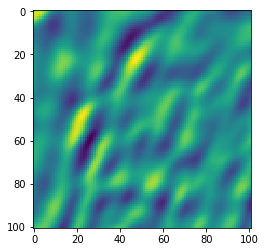

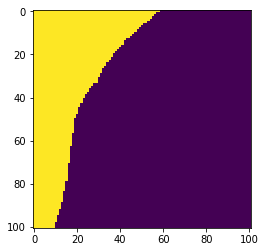

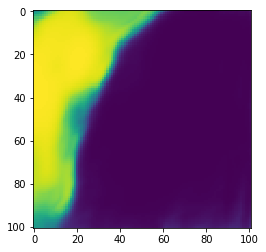

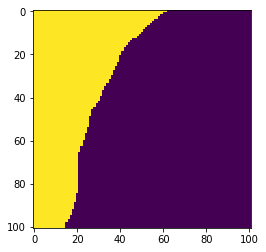

In [27]:
plt.imshow(X_val[ix,:,:,0])
plt.show()

plt.imshow(Y_val[ix,:,:,0])
#tmp = np.squeeze(Y_train[ix]).astype(np.float32)
#plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

#show raw predictions
plt.imshow(preds_val[ix,:,:,0])
plt.show()

#show raw predictions
plt.imshow(preds_val[ix,:,:,0] > 0.15)
plt.show()

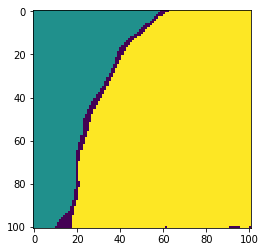

In [28]:
markers = np.zeros_like(preds_val[ix,:,:,0])
markers[preds_val[ix,:,:,0] < 0.1] = 2
markers[preds_val[ix,:,:,0] > 0.4] = 1
plt.imshow(markers)
plt.show()

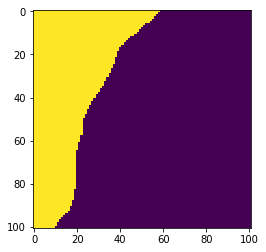

In [29]:
segmentation = watershed(preds_val[ix,:,:,0], markers)
segmentation[segmentation == 2] = 0
plt.imshow(segmentation)

In [30]:
segmentation

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [31]:
threshList = []
IoUList = []
IoUValList = []
for kk in tqdm(range(65)):
    thresh = 0.3 + 0.7*(1+kk)/65
    threshList.append(thresh)
    
    meanIoUVal = 0
    
    preds_val_ws = ModelUNet.WaterShedChangeAll(preds_val, lowThresh = 0.1, highThresh = thresh)
    meanIoUVal = np.array([ModelUNet.IoU(preds_val_ws[i], Y_val[i]) for i in range(Y_val.shape[0])])
    IoUValList.append(np.mean(meanIoUVal) )
    

100%|██████████| 65/65 [02:02<00:00,  1.88s/it]


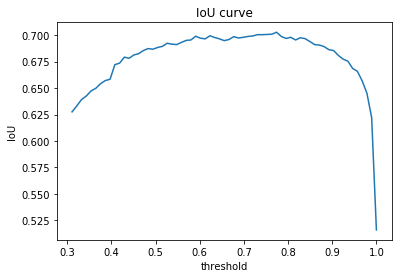

In [32]:
plt.title('IoU curve')
plt.ylabel('IoU')
plt.xlabel('threshold')

#plt.plot(threshList, IoUList)
plt.plot(threshList, IoUValList)

In [33]:
wsThresh = threshList[np.argmax(IoUValList)]
print('Thresh: {}  ExpectedIoU: {}'.format(wsThresh, max(IoUValList)))

Thresh: 0.7738461538461539  ExpectedIoU: 0.7027083333333333


## Threshold optimization

In [34]:
threshList = []
IoUList = []
IoUValList = []
for kk in tqdm(range(13)):
    thresh = (1+kk)/13
    threshList.append(thresh)
    preds_train_t = (preds_train > thresh).astype(np.uint8)
    preds_val_t = (preds_val > thresh).astype(np.uint8)
    meanIoU = np.array([ModelUNet.IoU(preds_train_t[i], Y_train0[i]) for i in range(Y_train0.shape[0])])
    IoUList.append(np.mean(meanIoU) )
    meanIoUVal = np.array([ModelUNet.IoU(preds_val_t[i], Y_val[i]) for i in range(Y_val.shape[0])])
    IoUValList.append(np.mean(meanIoUVal) )

100%|██████████| 13/13 [01:22<00:00,  6.32s/it]


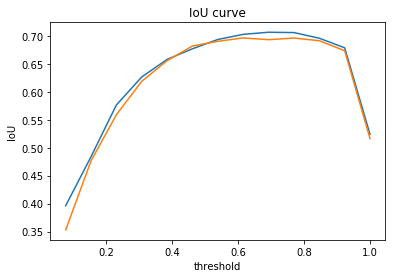

In [35]:
plt.title('IoU curve')
plt.ylabel('IoU')
plt.xlabel('threshold')

plt.plot(threshList, IoUList)
plt.plot(threshList, IoUValList)

In [36]:
thresh = threshList[np.argmax(IoUValList)]
print('Thresh: {}  ExpectedIoU: {}'.format(thresh, max(IoUValList)))

Thresh: 0.6153846153846154  ExpectedIoU: 0.6962500000000001


In [47]:
thresh = 0.5

# Predictions

In [37]:
X_test, d_test = ImageReader.ReadSegmentationImages(testFolder, depthFile, readMasks = False)
X_test = (X_test-X_train_mean)/(2*X_train_std)

#for i in tqdm(range(len(X_test))):
#    X_test[i] = image_datagen.standardize(X_test[i].astype(float))

  0%|          | 0/18000 [00:00<?, ?it/s]

Getting images and masks ... 


100%|██████████| 18000/18000 [08:44<00:00, 34.32it/s]


In [38]:
model_array = [
               #load_model('model-tgs-salt-Resnet.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
               #load_model('model-tgs-salt-ReflecConv.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
               #load_model('model-tgs-salt-Incep1.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
              ]

# Predict on train, val and test

preds_train = model.predict([X_train0, d_train0], verbose=1)
preds_val = model.predict([X_val, d_val], verbose=1)
preds_test = model.predict([X_test, d_test], verbose=1)

for savedModel in model_array:
    preds_train += savedModel.predict([X_train0, d_train0], verbose=1)
    preds_val += savedModel.predict([X_val, d_val], verbose=1)
    preds_test += savedModel.predict([X_test, d_test], verbose=1)

preds_train /= 1+len(model_array)
preds_val /= 1+len(model_array)
preds_test /= 1+len(model_array)


# Threshold predictions
preds_train_t = (preds_train > thresh).astype(np.uint8)
preds_val_t = (preds_val > thresh).astype(np.uint8)
preds_test_t = (preds_test > thresh).astype(np.uint8)


18000/18000 [==============================] - 204s 11ms/step


In [40]:
#Watershed predictions
preds_test_t = ModelUNet.WaterShedChangeAll(preds_test, lowThresh = 0.1, highThresh = wsThresh)

100%|██████████| 18000/18000 [00:42<00:00, 418.70it/s]


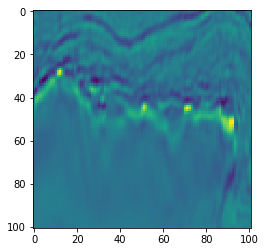

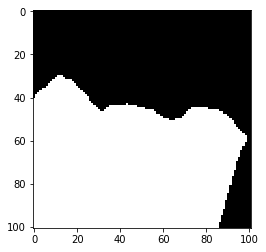

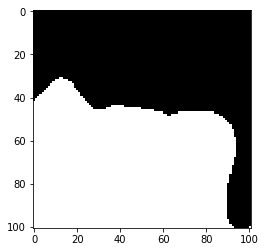

In [41]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_train_t))
plt.imshow(X_train0[ix,:,:,0])
plt.show()
#plt.imshow(Y_train[ix,:,:,0])
tmp = np.squeeze(Y_train0[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [42]:
lowPixCount = [imgId for imgId in range(len(preds_test_t)) if preds_test_t[imgId].sum() < 5 and preds_test_t[imgId].sum() > 0]
len(lowPixCount)

141

In [43]:
for imId in lowPixCount:
    preds_test_t[imId]=np.zeros( (101,101,1) )

# Prepare Submission

In [44]:
print(preds_test_t.shape)
preds_test = preds_test_t.reshape(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2])
print(preds_test.shape)

(18000, 101, 101, 1)
(18000, 101, 101)


In [45]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in tqdm(enumerate(test_ids))}
#pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in (enumerate(test_ids))}

In [46]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [47]:
import zipfile
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED

modes = { zipfile.ZIP_DEFLATED: 'deflated',
          zipfile.ZIP_STORED:   'stored',
          }

print('creating archive')
zf = zipfile.ZipFile('submission.zip', mode='w')
try:
    print('adding with compression mode {}'.format(modes[compression]))
    zf.write('submission.csv', compress_type=compression)
finally:
    print('closing')
    zf.close()

print('submission.zip')

creating archive
adding with compression mode deflated
closing
submission.zip


In [48]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.zip -m "UNet with dilation + watershed"

Successfully submitted to TGS Salt Identification Challenge

In [0]:
from google.colab import files
files.download('submission.zip')